In [1]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

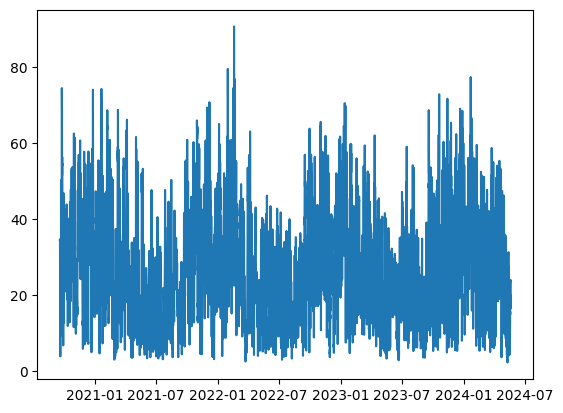

In [5]:
import matplotlib.pyplot as plt
plt.plot(merged_hornsea.index, merged_hornsea["wind_speed"])

In [1]:
from Preprocessing import * 

prep = Preprocessing()

merged_hornsea = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_hornsea":"nc_files", "ncep_gfs_hornsea":"nc_files"},
                                              deployment = False, merge_with_outage_data = True, json_file_path = "nc_files/REMIT", energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

merged_pes = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_pes":"nc_files", "ncep_gfs_pes":"nc_files"},
          deployment = False, merge_with_outage_data = False, energy_data_dict = {"Energy_data":"csv_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, ) 

# merged_demand = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_demand":"nc_files", "ncep_gfs_demand":"nc_files"},
#           deployment = False, merge_with_outage_data = True, energy_data_dict = {"Energy_data":"csv_files"},
#                                               non_numerical_columns = ["unavailabilityType", "affectedUnit"],
#                                               fft = False, )

INFO:root:Perform data cleaning on the weather data...
INFO:root:Merge weather stations...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:651: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  weather_data = weather_data.resample("30min", level = 1).mean().interpolate("time")
INFO:root:Merge with outages data (REMIT)...
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:326: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  outages_df = pd.concat([outages_df, json_data_with_date_ranges])
c:\Users\danie\Documents\AWP2_Repo\awp2\Preprocessing.py:326: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

In [2]:
merged_hornsea.to_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes.to_parquet("preprocessed_pes_with_energy.parquet")

In [ ]:
import comp_utils


def create_submission_data(original_data, wind_prediction, solar_prediction, date:str, api_key_file:str = "team_key.txt"):

    rebase_api_client = comp_utils.RebaseAPI(api_key = open(api_key_file).read())
    # read the required timestamps for the next day
    market_day = pd.DataFrame({"datetime":comp_utils.day_ahead_market_times(today_date=pd.to_datetime(date))})

    prediction = dict()

    for key in wind_prediction.keys():
        prediction[key] = wind_prediction[key] + solar_prediction[key]

    # get the datetime values from the data which was used to predict the forecast
    index = original_data[-prediction["0.1"].shape[0]:].index
    # merge the predictions with the timestamps to make a prediction
    forecasts = pd.DataFrame(prediction, index = index).reset_index().merge(market_day, left_on = "dtm", right_on = "datetime")
    forecasts.columns = ["dtm", "10", "20", "30", "40", "50", "60", "70", "80", "90", "datetime"]

    submissions = list()

    for index, row in forecasts.iterrows():
        submissions.append({"timestamp": str(pd.to_datetime(row["dtm"])).replace(" ", "T"),
                            "market_bid": row["50"],
                            "probalistic_forecast": row[["10", "20", "30", "40", "50", "60", "70", "80", "90"]].to_dict()})
        
    return {"market_day": date, "submissions": submissions}


#create_submission_data(merged_hornsea, wind_pred, solar_pred, "2024-05-17")

In [4]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit', "outage"])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

INFO:root:No features found to onehotencode.


In [17]:
feature_engineerer_wind.train_val_test_split_by_year(merged_hornsea, 6, 12)
feature_engineerer_wind.X_val

,affectedUnit,availableCapacity,cos_day,cos_dayofweek,cos_hour,cos_month,forecast_horizon,hoursSinceOutage,hoursUntilOutageEnd,outage,...,wind_speed_max_3h,wind_speed_max_6h,wind_speed_mean_3h,wind_speed_mean_6h,wind_speed_min_3h,wind_speed_min_6h,wind_speed_next_forecast,wind_speed_range_3h,wind_speed_std_3h,wind_speed_std_6h
dtm,,,,,,,,,,,,,,,,,,,,,
2022-11-19 23:30:00+00:00,HOWBO-3,336.0,-0.739074,0.200484,0.982963,0.5,25.0,36.0,18.45,1.0,...,8.022537,10.057893,7.660736,7.921043,7.288226,6.707885,7.692770,0.734311,0.274109,1.095192
2022-11-20 00:00:00+00:00,HOWBO-3,336.0,-0.669131,0.623490,1.000000,0.5,24.0,36.5,17.95,1.0,...,8.261846,9.807936,7.796908,7.855535,7.295782,6.621997,7.784216,0.966064,0.356592,1.032163
2022-11-20 00:30:00+00:00,HOWBO-3,336.0,-0.669131,0.623490,0.982963,0.5,24.5,37.0,0.45,1.0,...,8.308135,9.525291,7.797297,7.821460,7.307849,6.659984,7.898334,1.000286,0.383224,0.918925
2022-11-20 01:00:00+00:00,HOWBO-3,336.0,-0.669131,0.623490,0.965926,0.5,25.0,37.5,16.95,1.0,...,8.354424,9.242646,7.797686,7.787386,7.319916,6.697971,8.012451,1.034508,0.409856,0.805688
2022-11-20 01:30:00+00:00,HOWBO-3,336.0,-0.669131,0.623490,0.915976,0.5,24.0,38.0,16.45,1.0,...,8.432795,9.095392,7.831170,7.798877,7.345747,6.786358,8.137627,1.087048,0.443203,0.735316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-18 21:30:00+00:00,None,400.0,-0.913545,-0.222521,0.786566,0.5,24.5,0.0,0.00,0.0,...,12.195292,14.767995,10.912303,11.324180,9.489032,9.195598,12.452869,2.706260,1.127096,1.856452
2023-11-18 22:00:00+00:00,None,400.0,-0.913545,-0.222521,0.866025,0.5,25.0,0.0,0.00,0.0,...,12.331080,14.689912,11.149415,11.248326,9.609881,9.195598,12.580880,2.721199,1.124619,1.755847
2023-11-18 22:30:00+00:00,None,400.0,-0.913545,-0.222521,0.915976,0.5,25.5,0.0,0.00,0.0,...,12.463663,14.257876,11.391884,11.194491,9.918613,9.195598,12.816435,2.545050,1.030232,1.632249


In [18]:
feature_engineerer_wind.X_test

,affectedUnit,availableCapacity,cos_day,cos_dayofweek,cos_hour,cos_month,forecast_horizon,hoursSinceOutage,hoursUntilOutageEnd,outage,...,wind_speed_max_3h,wind_speed_max_6h,wind_speed_mean_3h,wind_speed_mean_6h,wind_speed_min_3h,wind_speed_min_6h,wind_speed_next_forecast,wind_speed_range_3h,wind_speed_std_3h,wind_speed_std_6h
dtm,,,,,,,,,,,,,,,,,,,,,
2023-11-19 23:30:00+00:00,None,400.0,-0.739074,0.811745,0.982963,0.5,25.0,0.0,0.0,0.0,...,10.887956,11.970496,9.662283,9.982485,8.587469,8.391882,10.937024,2.300488,0.891649,1.192969
2023-11-20 00:00:00+00:00,None,400.0,-0.669131,1.000000,1.000000,0.5,24.0,0.0,0.0,0.0,...,11.031380,11.868827,9.721503,9.884311,8.479493,8.218693,10.892900,2.551887,0.983165,1.177825
2023-11-20 00:30:00+00:00,None,400.0,-0.669131,1.000000,0.982963,0.5,24.5,0.0,0.0,0.0,...,11.098181,11.681338,9.884969,9.867041,8.650796,8.209717,10.781283,2.447386,0.961107,1.138010
2023-11-20 01:00:00+00:00,None,400.0,-0.669131,1.000000,0.965926,0.5,25.0,0.0,0.0,0.0,...,11.164983,11.493849,10.048434,9.849771,8.822099,8.200740,10.669667,2.342884,0.939050,1.098195
2023-11-20 01:30:00+00:00,None,400.0,-0.669131,1.000000,0.915976,0.5,24.0,0.0,0.0,0.0,...,11.162544,11.368181,10.187688,9.868795,9.027661,8.257817,10.809746,2.134883,0.853907,1.051730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-19 21:30:00+00:00,HOWBO-1,0.0,-0.874347,0.623490,0.786566,-0.5,33.5,1251.0,712.5,1.0,...,6.737149,6.750132,6.371855,6.013482,6.060573,5.334563,6.606133,0.676576,0.266459,0.493992
2024-05-19 22:00:00+00:00,HOWBO-1,0.0,-0.874347,0.623490,0.866025,-0.5,34.0,1251.5,712.0,1.0,...,6.769478,6.784282,6.404458,6.062979,6.073418,5.343570,6.561244,0.696061,0.276990,0.501615
2024-05-19 22:30:00+00:00,HOWBO-1,0.0,-0.874347,0.623490,0.915976,-0.5,34.5,1252.0,786.5,1.0,...,6.801740,6.809205,6.430809,6.110744,6.073654,5.355576,6.586409,0.728086,0.285817,0.493502


In [40]:
from Preprocessing import * 

prep = Preprocessing()

merged_pes2 = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_pes":"api_files", "ncep_gfs_pes":"api_files"},
          deployment = True, merge_with_outage_data = False, energy_data_dict = {"Energy_Data":"api_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

merged_hornsea2 = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_hornsea":"api_files", "ncep_gfs_hornsea":"api_files"},
          deployment = True, merge_with_outage_data = True, energy_data_dict = {"Energy_Data":"api_files"},
                                              non_numerical_columns = ["unavailabilityType", "affectedUnit"],
                                              fft = False, )

INFO:root:Perform data cleaning on the weather data...
INFO:root:Merge weather stations...
INFO:root:Merge with energy data...


ValueError: No objects to concatenate

### __Wind Energy Forecast__

__baseline__

In [5]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_wind\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_wind\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_wind\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_wind\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_wind\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_wind\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_wind\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_wind\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_wind\qr_model_quantile_0

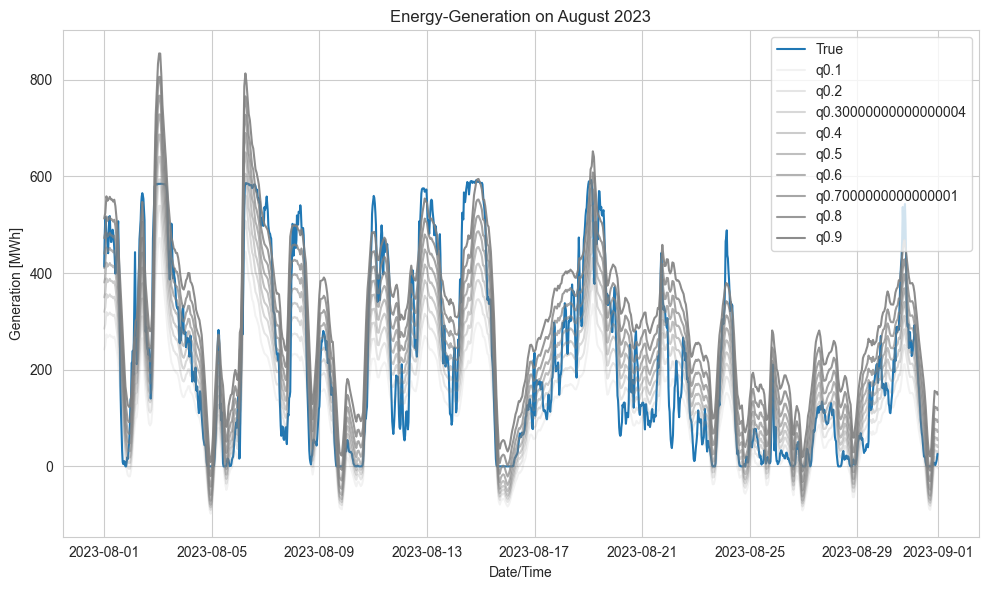

In [12]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test.index, qr_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

In [16]:
feature_engineerer_wind_baseline.y_test.index

DatetimeIndex(['2023-05-21 23:30:00+00:00', '2023-05-22 00:00:00+00:00',
               '2023-05-22 00:30:00+00:00', '2023-05-22 01:00:00+00:00',
               '2023-05-22 01:30:00+00:00', '2023-05-22 02:00:00+00:00',
               '2023-05-22 02:30:00+00:00', '2023-05-22 03:00:00+00:00',
               '2023-05-22 03:30:00+00:00', '2023-05-22 04:00:00+00:00',
               ...
               '2023-11-19 19:00:00+00:00', '2023-11-19 19:30:00+00:00',
               '2023-11-19 20:00:00+00:00', '2023-11-19 20:30:00+00:00',
               '2023-11-19 21:00:00+00:00', '2023-11-19 21:30:00+00:00',
               '2023-11-19 22:00:00+00:00', '2023-11-19 22:30:00+00:00',
               '2023-11-19 23:00:00+00:00', '2023-11-19 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='dtm', length=8737, freq=None)

__xgboost__

In [6]:
importlib.reload(model_utils)
import numpy as np

quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_wind"
hyperparams = {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.01,
            "max_depth": 8
        }

xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False, hyperparams=hyperparams, num_boost_round=45, early_stopping_rounds=10)
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

[0]	Train-quantile:97.92736	Val-quantile:88.89135
[1]	Train-quantile:96.87744	Val-quantile:87.93482
[2]	Train-quantile:95.83678	Val-quantile:86.98485
[3]	Train-quantile:94.81203	Val-quantile:86.05016
[4]	Train-quantile:93.80192	Val-quantile:85.13458
[5]	Train-quantile:92.80041	Val-quantile:84.23242
[6]	Train-quantile:91.81060	Val-quantile:83.34194
[7]	Train-quantile:90.83706	Val-quantile:82.46068
[8]	Train-quantile:89.87563	Val-quantile:81.59277
[9]	Train-quantile:88.92580	Val-quantile:80.73860
[10]	Train-quantile:87.98459	Val-quantile:79.88811
[11]	Train-quantile:87.06004	Val-quantile:79.05230
[12]	Train-quantile:86.14381	Val-quantile:78.22486
[13]	Train-quantile:85.23566	Val-quantile:77.40800
[14]	Train-quantile:84.34130	Val-quantile:76.59923
[15]	Train-quantile:83.45971	Val-quantile:75.80396
[16]	Train-quantile:82.58738	Val-quantile:75.01741
[17]	Train-quantile:81.72215	Val-quantile:74.23584
[18]	Train-quantile:80.86908	Val-quantile:73.46751
[19]	Train-quantile:80.03064	Val-quantile

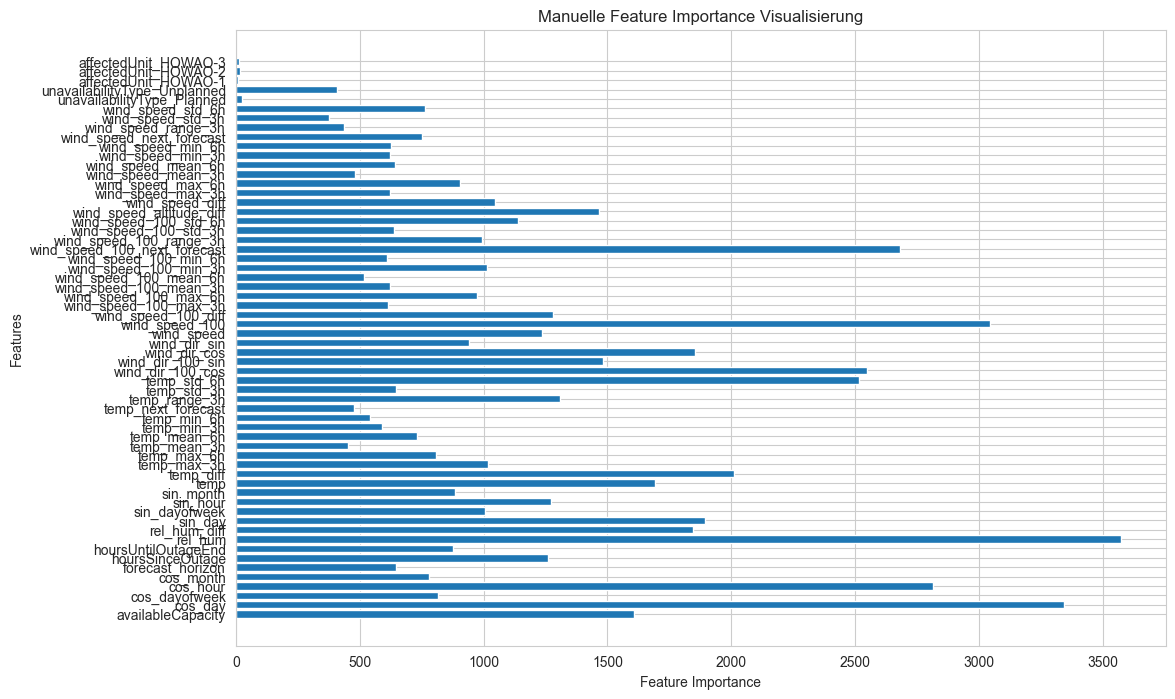

In [18]:
xgboost_model_wind.plot_feature_importance()

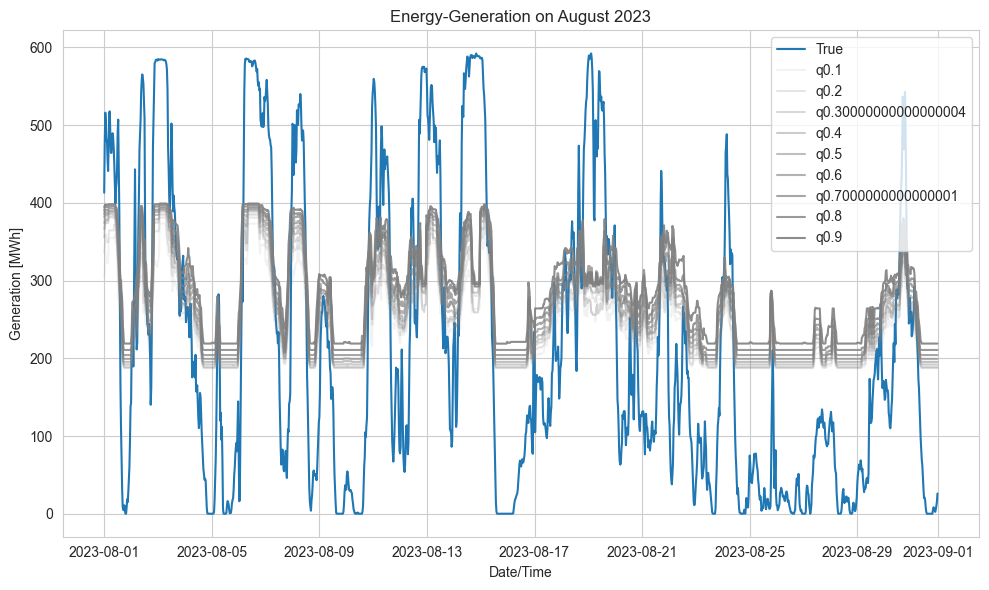

In [21]:
xgboost_model_wind.plot_quantils(daterange=feature_engineerer_wind.y_test.index, y=xgboost_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

### __Solar Energy Forecast__

__baseline modell__

In [22]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=True)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Loaded pretrained Quantile Regressor model for quantile 0.1 from qr_model_solar\qr_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from qr_model_solar\qr_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.30000000000000004 from qr_model_solar\qr_model_quantile_0.30000000000000004.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from qr_model_solar\qr_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from qr_model_solar\qr_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from qr_model_solar\qr_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7000000000000001 from qr_model_solar\qr_model_quantile_0.7000000000000001.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from qr_model_solar\qr_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from qr_model_solar\qr_model_q

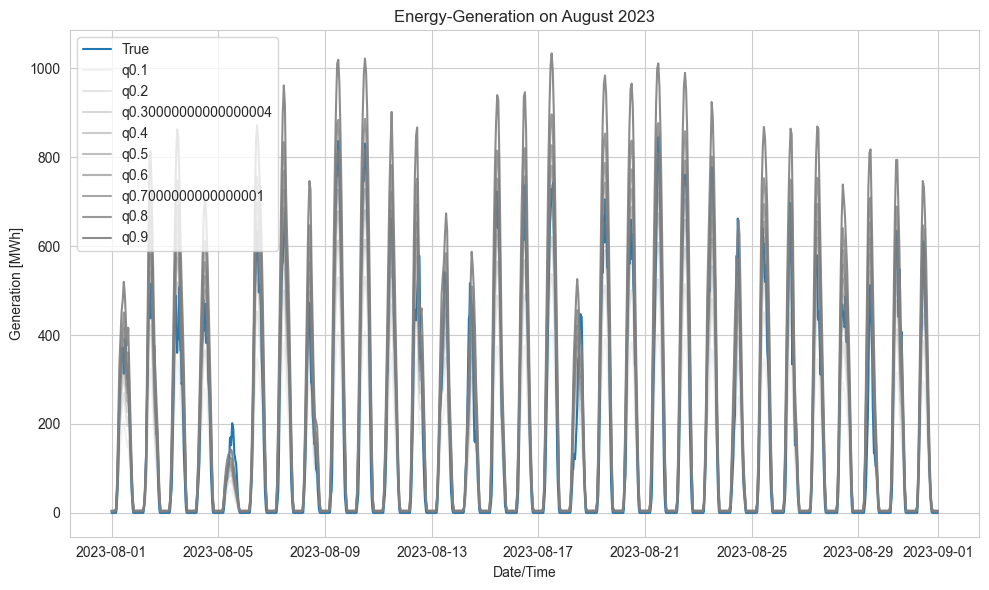

In [24]:
qr_model_solar.plot_quantils(daterange=feature_engineerer_solar_baseline.y_test.index, y=qr_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023)

__xgboost__

In [25]:
quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_solar"

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

[0]	Train-quantile:44.08707	Val-quantile:89.95057
[1]	Train-quantile:42.03986	Val-quantile:86.05513
[2]	Train-quantile:40.15751	Val-quantile:82.27772
[3]	Train-quantile:38.39230	Val-quantile:78.74044
[4]	Train-quantile:36.76298	Val-quantile:75.32009
[5]	Train-quantile:35.21154	Val-quantile:72.08206
[6]	Train-quantile:33.74628	Val-quantile:68.97437
[7]	Train-quantile:32.34835	Val-quantile:66.01293
[8]	Train-quantile:31.01052	Val-quantile:63.16004
[9]	Train-quantile:29.74307	Val-quantile:60.47123
[10]	Train-quantile:28.53109	Val-quantile:57.89782
[11]	Train-quantile:27.39076	Val-quantile:55.41591
[12]	Train-quantile:26.30762	Val-quantile:53.08895
[13]	Train-quantile:25.28495	Val-quantile:50.84766
[14]	Train-quantile:24.31522	Val-quantile:48.71098
[15]	Train-quantile:23.38586	Val-quantile:46.63809
[16]	Train-quantile:22.50596	Val-quantile:44.66774
[17]	Train-quantile:21.65688	Val-quantile:42.87176
[18]	Train-quantile:20.85787	Val-quantile:41.13363
[19]	Train-quantile:20.10806	Val-quantile

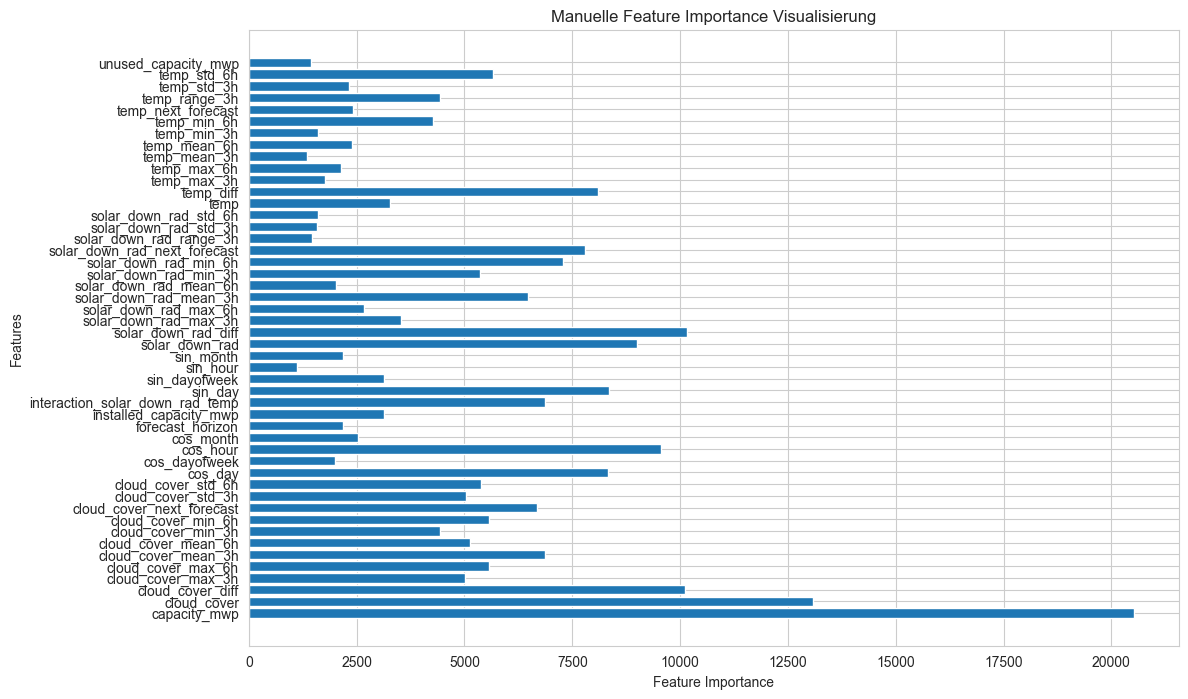

In [26]:
xgboost_model_solar.plot_feature_importance()

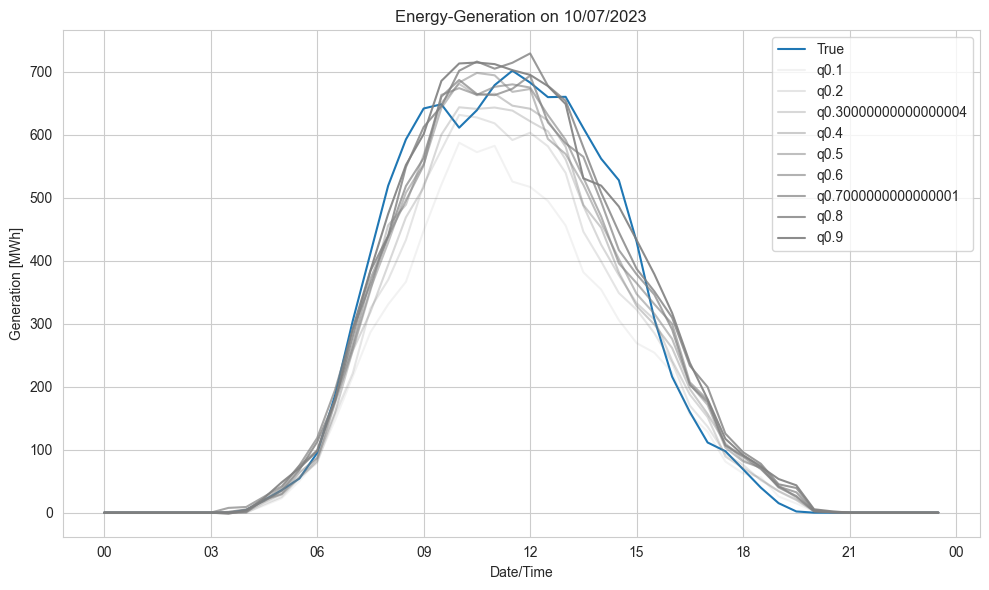

In [31]:
xgboost_model_solar.plot_quantils(daterange=feature_engineerer_solar.y_test.index, y=xgboost_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1), year=2023, month = 7, day = 10)

### __Lightgbm implementation__

In [28]:
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

[LightGBM] [Info] Total Bins 11963
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 66
[LightGBM] [Info] Start training from score 9.924001
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 9.77323	valid's quantile: 11.6876
[100]	train's quantile: 8.28087	valid's quantile: 11.6754
Early stopping, best iteration is:
[71]	train's quantile: 9.01414	valid's quantile: 11.5612
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_wind\qr_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 11963
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 66
[LightGBM] [Info] Start training from score 46.169998
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 13.7512	valid's quantile: 17.9513
[100]	train's quantile: 12.1263	valid's quantile: 18.0026
Early stopping, best iteration is:
[69]	train's quantile: 13.0298	valid's quantile: 17.8289
Saved Qu

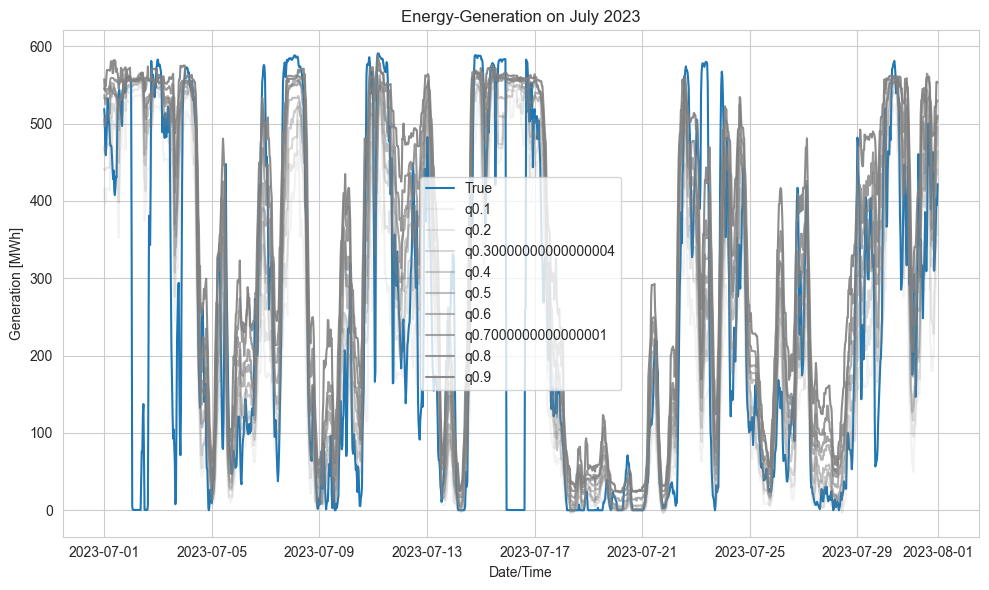

In [38]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind.q_predictions, quantiles, year = 2023, month=7)

In [41]:
quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar.pinball_score()}")

[LightGBM] [Info] Total Bins 10379
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 48
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 4.92774	valid's quantile: 6.55347
[100]	train's quantile: 3.81647	valid's quantile: 5.80912
Early stopping, best iteration is:
[89]	train's quantile: 3.92965	valid's quantile: 5.7881
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_solar\qr_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 10379
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 48
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 6.88751	valid's quantile: 9.42509
[100]	train's quantile: 5.69335	valid's quantile: 9.12746
Early stopping, best iteration is:
[90]	train's quantile: 5.77021	valid's quantile: 9.09761
Saved Quantile Regressor model for quantile 0.2 to lgbm_model_solar\qr_model_quantile_0.2.pkl
[LightGBM] [Info] Tot

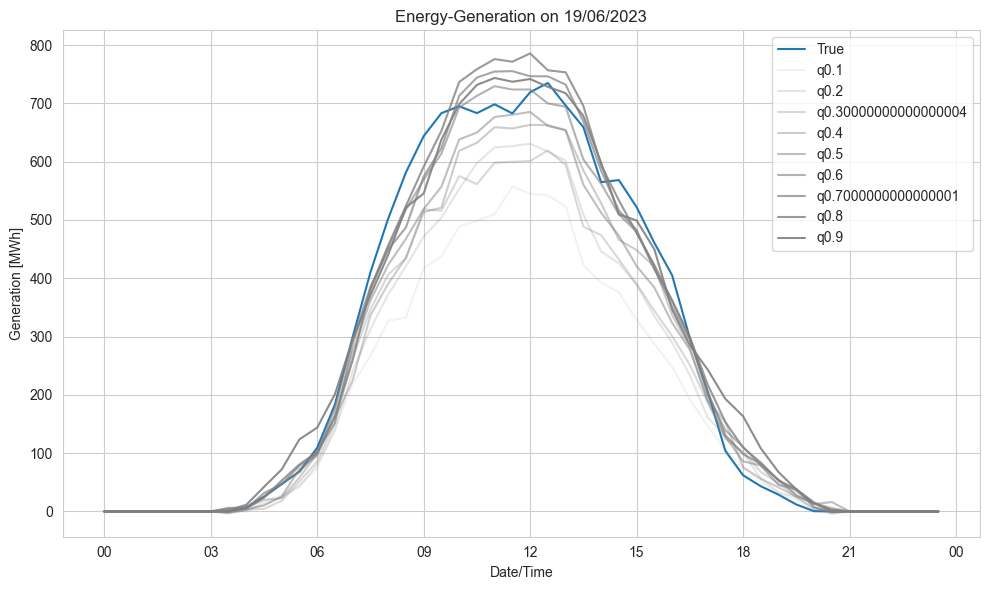

In [43]:
lgbm_model_solar.plot_quantils(feature_engineerer_solar.y_test.index, lgbm_model_solar.q_predictions, quantiles, year=2023, month=6, day=19)

In [19]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)

import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit', "outage"])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

INFO:root:No features found to onehotencode.


In [34]:
import neural_networks
import numpy as np
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_wind = neural_networks.Trainer(feature_engineerer_wind, neural_networks.q_model,quantiles)
nn_wind.train_and_test()

c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\danie\anaconda3\envs\awp2\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 1181.6455078125
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 1094.1888427734375
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 1025.10693359375
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 905.12646484375
40. epoche startet: 
41. epoche startet: 
42. epoche startet: 

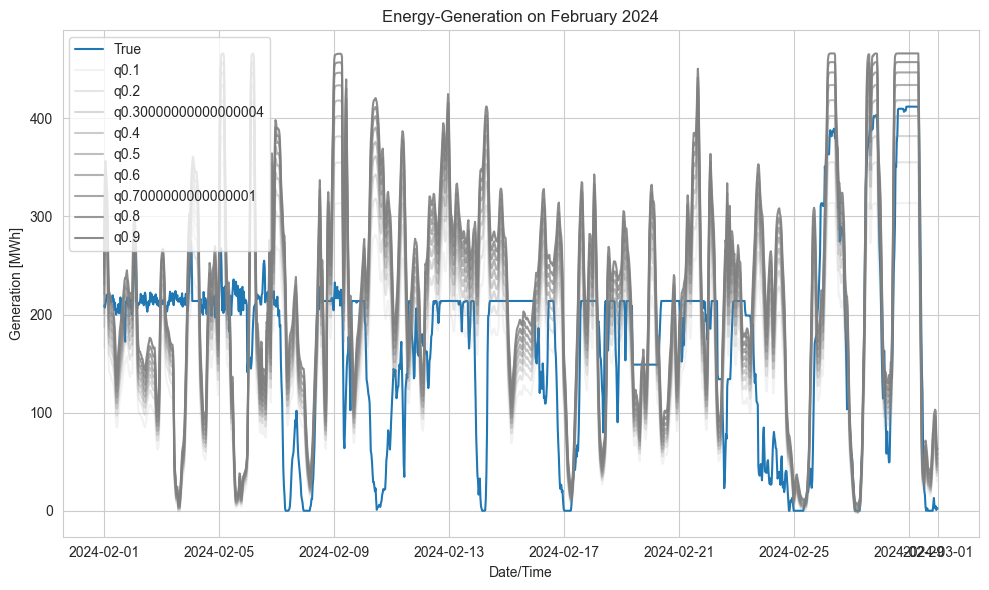

In [37]:
nn_wind.plot_quantils(feature_engineerer_wind.y_test.index, nn_wind.q_prediction_nn, quantiles, year = 2024, month = 2)

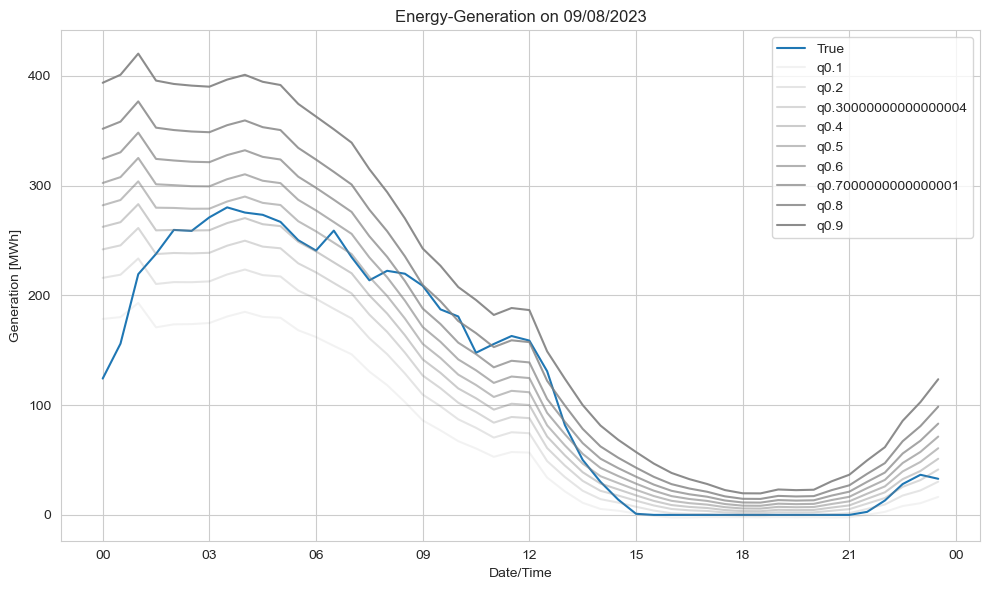

In [18]:
nn_wind.plot_quantils(feature_engineerer_wind.y_test.index, nn_wind.q_prediction_nn, quantiles, day=9)

In [19]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn
quantiles = np.arange(0.1, 1.0, 0.1)

nn_solar = neural_networks.Trainer(feature_engineerer_solar, neural_networks.q_model, quantiles, in_shape=30)
nn_solar.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 89.52793884277344
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 84.58145141601562
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 81.36831665039062
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 80.07588195800781
40. epoche startet: 
41. epoche startet: 
42. epoche start

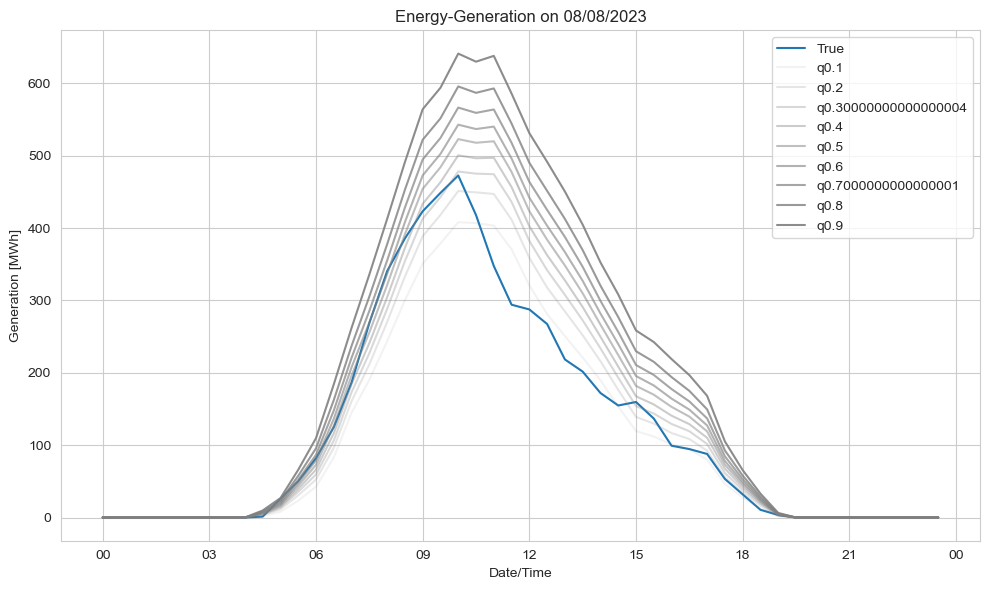

In [20]:
nn_solar.plot_quantils(feature_engineerer_solar.y_test.index, nn_solar.q_prediction_nn, quantiles, day=8)